In [12]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

In [14]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd


In [3]:
#TODO load MNIST data set
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

#TODO Prepare the test samples as above
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [5]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [6]:
#TODO configure the model to use a binary crossentropy loss and the Adam optimizer:
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TODO complete fit(). As a starting point set epoch to 50, batch size to 256, shuffle data, and use x_test as a validation set.
#Later You can experiment with those values
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0094 - loss: 0.3858 - val_accuracy: 0.0106 - val_loss: 0.1884
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0118 - loss: 0.1786 - val_accuracy: 0.0110 - val_loss: 0.1522
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0097 - loss: 0.1479 - val_accuracy: 0.0099 - val_loss: 0.1330
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0097 - loss: 0.1308 - val_accuracy: 0.0103 - val_loss: 0.1212
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0101 - loss: 0.1201 - val_accuracy: 0.0112 - val_loss: 0.1129
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0104 - loss: 0.1125 - val_accuracy: 0.0108 - val_loss: 0.1071
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0110 - loss: 0.1074 - val_accuracy: 0.0106 - val_loss: 0.1028
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0117 - loss: 0.1034 - val_accuracy: 0

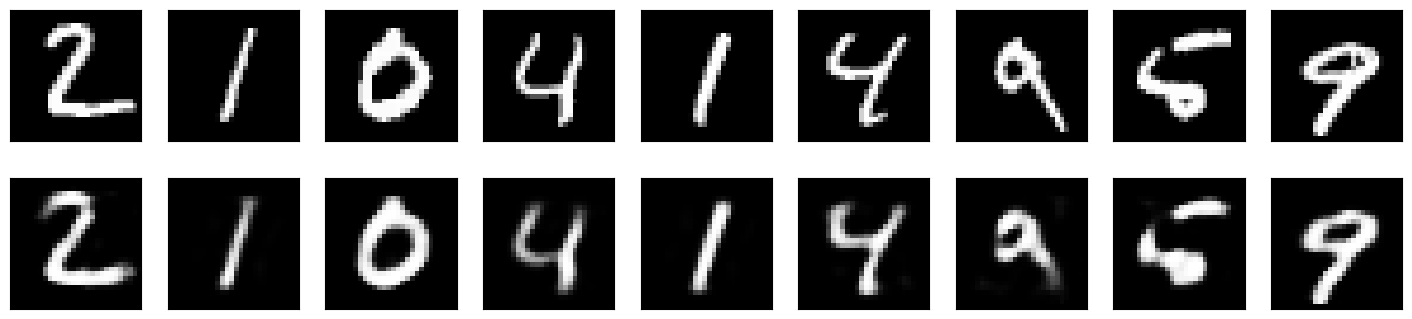

In [7]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
#TODO load MNIST data set and convert it to [0,1] range like before.
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

#TODO Prepare the test samples as above
x_test = x_train.astype('float32') / 255.
x_test = np.reshape(x_train, (len(x_train), 28, 28, 1))

In [10]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
#TODO configure model to use a binary crossentropy loss, and the Adam optimizer:

autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
#TODO complete fit(). Set epoch to 10, batch size to 128, shuffle data, and use x_test as a validation set.
#You can experiment with those values. If training takes a lot of time, try to reduce the number of epochs (but monitor loss value).

autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

decoded_imgs = autoencoder.predict(x_test)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.7923 - loss: 0.3235 - val_accuracy: 0.7999 - val_loss: 0.1505
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8025 - loss: 0.1440 - val_accuracy: 0.8058 - val_loss: 0.1307
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8065 - loss: 0.1280 - val_accuracy: 0.8086 - val_loss: 0.1215
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8085 - loss: 0.1200 - val_accuracy: 0.8088 - val_loss: 0.1155
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8094 - loss: 0.1147 - val_accuracy: 0.8106 - val_loss: 0.1115
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8099 - loss: 0.1110 - val_accuracy: 0.8110 - val_loss: 0.1087
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8105 - loss: 0.1085 - val_accuracy: 0.8109 - val_loss: 0.1067
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8110 - loss: 0.1067 - val_accuracy:

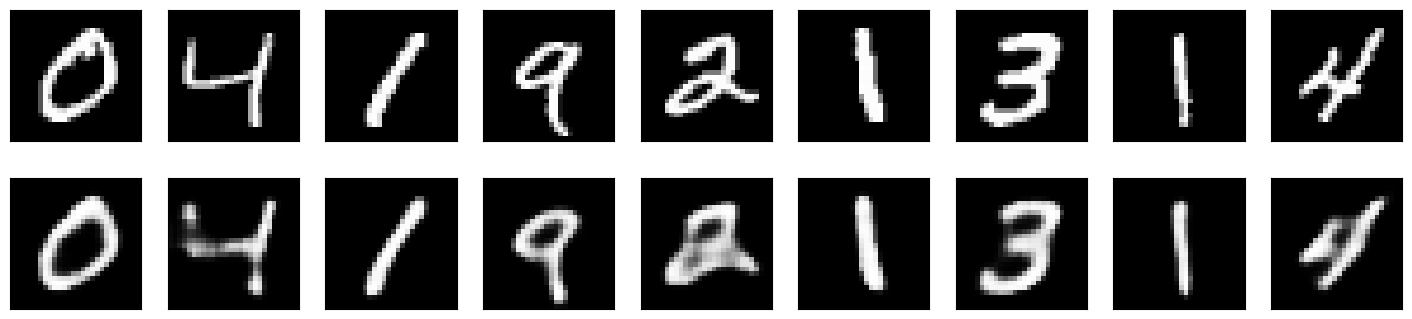

In [11]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [16]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
class GAN(tf.keras.Model):
    """ a basic GAN class
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)


def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


In [18]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [19]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

In [24]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, 1, 1, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [21]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

Epoch: 49 | disc_loss: 0.8266164660453796 | gen_loss: 1.241468071937561


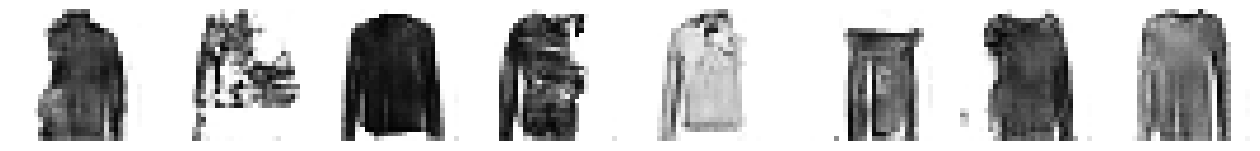

In [25]:
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)